In [1]:
#reading raw rr interval vs sleep grade into a dataframe:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
rri_sleep_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Driver_Drowsiness/RRIS_Database.csv',)
rri_sleep_df = rri_sleep_df[['RR Interval','Sleep Stage']]
rri_sleep_df.tail()

,RR Interval,Sleep Stage
106508,"[0.41015625, 0.55859375, 0.67578125, 27.71484375]",0
106509,"[2.890625, 3.33984375, 0.41015625, 22.328125]",0
106510,[0.23046875],0
106511,[],0
106512,"[16.12109375, 0.32421875, 1.00390625, 0.847656...",0


In [2]:
#writing a function to process the rri_sleep_df rr intervals (initially strings)
def process_intervals(rr_string_interval):
  nums = []
  for char in rr_string_interval.split():
    if char[0] == '[':
        char = char[1:]
    elif char[-1] == ']':
        char = char[:-1]
    try:
        num = eval(char)
        nums.append(num)
    except:
        pass
  return nums

In [3]:
#making list for rr inteval/sleep stage

rr_intervals,sleep_stages = [],[]

for row_index in range(len(rri_sleep_df)):
  sample = rri_sleep_df.iloc[row_index]
  rr_string_interval = sample['RR Interval']
  rr_string_interval = process_intervals(rr_string_interval)
  rr_interval = []
  for item in rr_string_interval:
    try:
      rr_interval.append(item[0])
    except:
      rr_interval.append(float(item))
  rr_intervals.append(rr_interval)
  sleep_stages.append(float((sample['Sleep Stage'])))

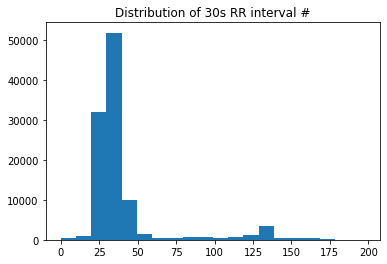

Median: 32
Standard Deviation: 27.274354249331584
0.9046031939763222


In [24]:
import statistics as stats
rr_interval_lens = [len(rri) for rri in rr_intervals]
plt.title('Distribution of 30s RR interval #')
plt.hist(rr_interval_lens,bins=20)
plt.show()

median = stats.median(rr_interval_lens)
std = stats.stdev(rr_interval_lens)

print(f'Median: {median}')
print(f'Standard Deviation: {std}')


ndevs = 1
print(len([rri for rri in rr_interval_lens if rri in range(int(median-std*ndevs),int(median+std*ndevs))])/len(rr_interval_lens))

In [25]:
#calculating # of samples w/i +-3 SD of the median

#RR Interval Length Summary Stats
#median = 30.31886889
#std = 4.42046041854777
#ndevs = 3

count = 0 
for index,rrinterval in enumerate(rr_intervals):
  #if len(rrinterval)>=(median-std*ndevs) and len(rrinterval)<=(median+std*ndevs):
  if len(rrinterval)>=int(median-std*ndevs) and len(rrinterval)<=int(median+std*ndevs):
     if sleep_stages[index]==0 or sleep_stages[index]==1:
        count+=1
print(count)
print()

31639



In [27]:
#trimming dataset to only include rr intervals between lens 17 --> 44 and sleep stages between [0,1]
valid_rr_intervals, valid_sleep_stages = [], []
for index,rr_interval in enumerate(rr_intervals):
  if len(rr_interval)>=int(median-std*ndevs) and len(rr_interval)<=int(median+std*ndevs):
    if sleep_stages[index]==0 or sleep_stages[index]==1:
      valid_rr_intervals.append(rr_interval)
      valid_sleep_stages.append(int(sleep_stages[index]))
print(len(valid_rr_intervals))

31639


In [28]:
#noramlizing/scaling all rr intervals
from sklearn.preprocessing import RobustScaler

clean_rr_intervals = [0]*len(valid_rr_intervals)

for index,dirty_rr_interval in enumerate(valid_rr_intervals):
  transformer = RobustScaler().fit(np.array(dirty_rr_interval).reshape(-1,1))
  transformed_arr = transformer.transform(np.array(dirty_rr_interval).reshape(-1,1))
  transformed_arr = transformed_arr.T
  clean_rr_intervals[index] = transformed_arr.tolist()[0]
print(clean_rr_intervals[0])

[0.17647058823529413, 0.6470588235294118, 0.4117647058823529, 0.17647058823529413, -1.0, -0.6470588235294118, -0.6470588235294118, -1.1176470588235294, -0.058823529411764705, -0.4117647058823529, 0.17647058823529413, 0.6470588235294118, 0.058823529411764705, 1.0, 0.29411764705882354, 0.4117647058823529, -0.17647058823529413, 0.29411764705882354, 0.4117647058823529, 0.5294117647058824, 0.4117647058823529, 0.5294117647058824, -0.058823529411764705, -0.6470588235294118, -1.1176470588235294, -1.2352941176470589, -0.4117647058823529, -1.2352941176470589, -0.6470588235294118, -0.5294117647058824, -0.29411764705882354, 0.29411764705882354, -0.17647058823529413, 0.29411764705882354]


In [29]:
#padding zeros to end of smaller rr interval arrays
max_rr_interval_num = max([len(rr_interval) for rr_interval in clean_rr_intervals])
for rr_interval in clean_rr_intervals:
  if len(rr_interval)<max_rr_interval_num:
    add_zero_num = max_rr_interval_num-len(rr_interval)
    for _ in range(add_zero_num):
      rr_interval.append(0)
#renaming clearn_rr_intervals --> RR_intervals
RR_intervals = clean_rr_intervals
RR_intervals = np.array(RR_intervals)
print(RR_intervals.shape)

(31639, 59)


In [30]:
#pulling function that makes recurrance plots on passed series data
from sklearn import metrics

def recurrence_plot(s, eps=None, steps=None):
  if eps==None: eps=0.1
  if steps==None: steps=10
  d = metrics.pairwise.pairwise_distances(s)
  d = np.floor(d / eps)
  d[d > steps] = steps
  #Z = squareform(d)
  return d

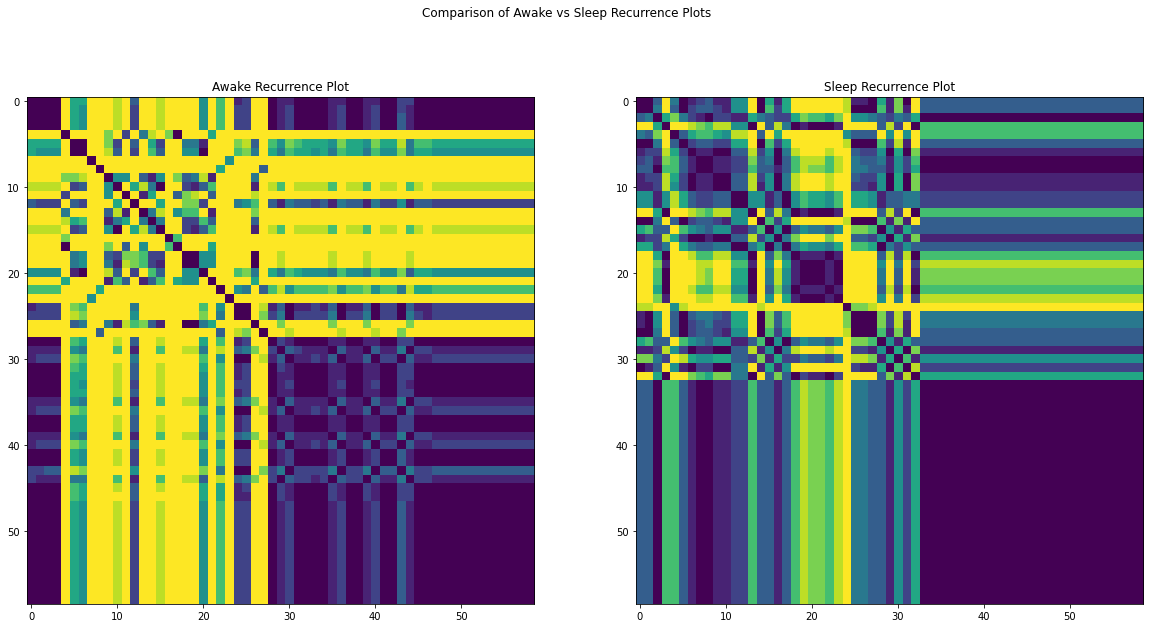

In [31]:
#pulling an awake vs sleep stage index

#making a temp list so we can pull indices where person was awake vs in varying degrees of sleep
valid_sleep_stages_list = list(valid_sleep_stages)
awake_indicies = [index for index,sleep_stage in enumerate(valid_sleep_stages_list) if sleep_stage==0]
sleep_indicies = [index for index,sleep_stage in enumerate(valid_sleep_stages_list) if sleep_stage==1]

#making a recurrance plot of randomly chosen awake vs sleep
rand_wake_index = np.random.choice(awake_indicies)
rand_sleep_index = np.random.choice(sleep_indicies)

awake_rp = recurrence_plot(RR_intervals[rand_wake_index,:].reshape(-1,1))
sleep_rp = recurrence_plot(RR_intervals[rand_sleep_index,:].reshape(-1,1))

fig, axs = plt.subplots(1,2,figsize=(20,10))
fig.suptitle('Comparison of Awake vs Sleep Recurrence Plots')
axs[0].imshow(awake_rp)
axs[0].set_title('Awake Recurrence Plot')
axs[1].imshow(sleep_rp)
axs[1].set_title('Sleep Recurrence Plot')
fig.show()

In [33]:
from sklearn.preprocessing import normalize
#applying the rp function so each interval so we can create our X database
X_data = np.empty((31639,59,59))

for index in range(X_data.shape[0]):
  RR_interval = RR_intervals[index].reshape(-1,1)
  interval_rp = recurrence_plot(RR_interval)
  interval_rp = normalize(interval_rp)
  X_data[index,:,:] = interval_rp
print(X_data.shape)

(31639, 59, 59)


In [34]:
#test-train splitting our data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, np.array(valid_sleep_stages), test_size=0.1, shuffle=True)
#reshaping x vectors to be 4d
x_train = X_train.reshape(X_train.shape[0], 59,59,1)
x_test = X_test.reshape(X_test.shape[0], 59,59,1)
print(y_train)

[0 0 0 ... 0 1 0]


In [61]:
#building CNN to classify between awake vs sleep
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import metrics
from keras import optimizers

model = Sequential(name='Sleep_Classifier_v1')

model.add(Conv2D(filters=64,kernel_size=2,strides=(1, 1),padding='valid',activation='relu',input_shape=(59,59,1), data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
model.add(Dropout(0.1))
model.add(layers.Conv2D(filters=256,kernel_size=3,strides=(1, 1),padding='valid',activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))
model.add(Dropout(0.1))
model.add(layers.Conv2D(filters=512,kernel_size=4,strides=(1, 1),padding='valid',activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))
model.add(Dropout(0.1))
model.add(layers.Conv2D(filters=1024,kernel_size=4,strides=(1, 1),padding='valid',activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))
model.add(Dropout(0.1))  
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='BinaryCrossentropy', optimizer='ADAM',metrics=['accuracy'])
model.summary()

Model: "Sleep_Classifier_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 58, 58, 64)        320       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 29, 29, 64)        0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 27, 27, 256)       147712    
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 10, 10, 512

Epoch 1/15
801/801 [==============================] - 18s 22ms/step - loss: 0.5639 - accuracy: 0.8820 - val_loss: 0.3379 - val_accuracy: 0.8919
Epoch 2/15
801/801 [==============================] - 18s 22ms/step - loss: 0.3478 - accuracy: 0.8869 - val_loss: 0.3415 - val_accuracy: 0.8919
Epoch 3/15
801/801 [==============================] - 18s 22ms/step - loss: 0.3520 - accuracy: 0.8833 - val_loss: 0.3400 - val_accuracy: 0.8919
Epoch 4/15
801/801 [==============================] - 17s 22ms/step - loss: 0.3427 - accuracy: 0.8889 - val_loss: 0.3617 - val_accuracy: 0.8919
Epoch 5/15
801/801 [==============================] - 18s 22ms/step - loss: 0.3403 - accuracy: 0.8877 - val_loss: 0.3310 - val_accuracy: 0.8919
Epoch 6/15
801/801 [==============================] - 18s 22ms/step - loss: 0.3414 - accuracy: 0.8883 - val_loss: 0.3393 - val_accuracy: 0.8919
Epoch 7/15
801/801 [==============================] - 17s 22ms/step - loss: 0.3451 - accuracy: 0.8858 - val_loss: 0.3301 - val_accuracy:

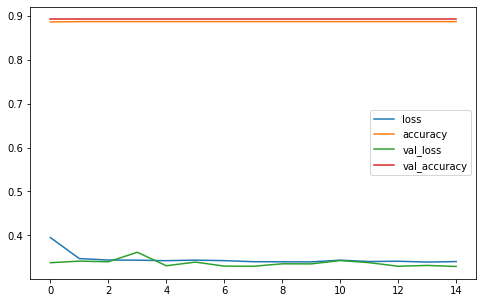

99/99 [==============================] - 1s 8ms/step - loss: 0.3324 - accuracy: 0.8894
test loss, test acc: [0.3323558568954468, 0.8893805146217346]


In [62]:
#training model
history = model.fit(x_train, y_train, epochs=15, validation_split=0.1, batch_size=32,shuffle=True)

#plotting history
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

#testing model
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)